# Exploring Co-Morbidities

## Read data files

In [2]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240531/data/data_matrix.csv')
icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')
admissionsDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/2023-11-10-blood-admissions.csv')
icdMappingsDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/unique_yash_items_no_geography.csv')

/tmp/ipykernel_711754/959883491.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')


In [3]:
icdDf.shape, datamatrixDf.shape, admissionsDf.shape, icdMappingsDf.shape

((456648, 7), (116754, 194), (436214, 20), (6235, 4))

## Explore ICD mappings

In [4]:
icdMappingsDf

,Input_Text,Matched_Label,Matched_Code,Similarity
0,4-Aminophenol derivatives,Poisoning: 4-Aminophenol derivatives,T39.1,0.688
1,4-Aminophenol derivatives causing adverse effe...,Adverse effects in the therapeutic use of 4-am...,Y45.5,0.922
2,"Abdominal aortic aneurysm, ruptured","Abdominal aortic aneurysm, ruptured",I71.3,1.000
3,"Abdominal aortic aneurysm, without mention of ...","Abdominal aortic aneurysm, without mention of ...",I71.4,1.000
4,Abdominal compartment syndrome,Traumatic compartment syndrome of abdomen,T79.A3,0.750
...,...,...,...,...
6230,Zoster ocular disease,Zoster ocular disease,B02.3,1.000
6231,Zoster with other complications,Zoster with other complications,B02.8,1.000
6232,Zoster with other nervous system involvement,"Other contact with chicken, sequela",W61.39XS,0.041
6233,Zoster without complication,Zoster without complication,B02.9,1.000


<Axes: >

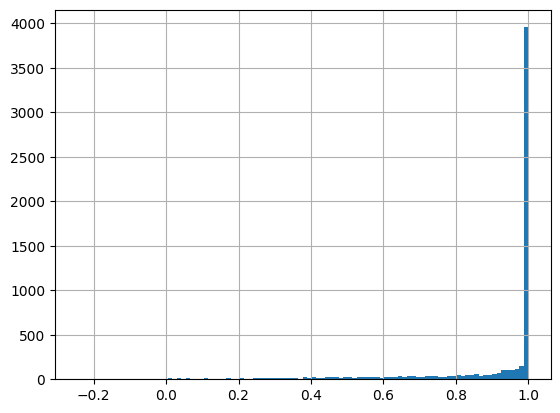

In [5]:
icdMappingsDf.Similarity.hist(bins=100)

## Filter patients from the cohort

In [6]:
filteredIcdDf = datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates().merge(
    admissionsDf[['PATIENT_ID', 'EPISODE_ID', 'start_date']],
    how='inner',
    left_on=['person_id', 'visit_occurrence_id'],
    right_on=['PATIENT_ID', 'EPISODE_ID']
).drop(
    columns=['person_id', 'visit_occurrence_id']
).merge(
    admissionsDf[['PATIENT_ID', 'EPISODE_ID', 'start_date']].add_suffix('_PREV'),
    how='inner',
    left_on=['PATIENT_ID'],
    right_on=['PATIENT_ID_PREV']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID']
).merge(
    icdDf,
    how='inner',
    left_on=['PATIENT_ID_PREV', 'EPISODE_ID_PREV'],
    right_on=['PATIENT_ID', 'EPISODE_ID'],
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID']
).rename(
    columns = {'PATIENT_ID_PREV': 'PATIENT_ID', 'EPISODE_ID_PREV': 'EPISODE_ID'}
)
filteredIcdDf = filteredIcdDf[((pd.to_datetime(filteredIcdDf.start_date) - pd.Timedelta(weeks=52)) < pd.to_datetime(filteredIcdDf.start_date_PREV)) & (pd.to_datetime(filteredIcdDf.start_date) >= pd.to_datetime(filteredIcdDf.start_date_PREV))]
filteredIcdDf = filteredIcdDf.drop(columns=['start_date', 'start_date_PREV'])
filteredIcdDf = filteredIcdDf.merge(
    icdMappingsDf,
    how='inner',
    left_on=['ICD_DESCRIPTION'],
    right_on=['Input_Text'],
)
# filteredIcdDf = icdDf.merge(
#     datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates(),
#     how='inner',
#     left_on=['PATIENT_ID', 'EPISODE_ID'],
#     right_on=['person_id', 'visit_occurrence_id']
#     )
# icdDf[['PATIENT_ID', 'EPISODE_ID']].drop_duplicates().shape, filteredIcdDf[['PATIENT_ID', 'EPISODE_ID']].drop_duplicates().shape, datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape
# (pd.to_datetime(filteredIcdDf.start_date) - pd.to_datetime(filteredIcdDf.start_date_PREV)).dt.days.hist(bins=100)
# filteredIcdDf[['PATIENT_ID', 'EPISODE_ID']].drop_duplicates().shape, filteredIcdDf[['PATIENT_ID_PREV', 'EPISODE_ID_PREV']].drop_duplicates().shape, datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates().shape
# filteredIcdDf[['PATIENT_ID']].drop_duplicates().shape, filteredIcdDf[['PATIENT_ID_PREV']].drop_duplicates().shape, datamatrixDf[['person_id']].drop_duplicates().shape
filteredIcdDf


,PATIENT_ID,EPISODE_ID,AUSTRALIAN_MODIFICATION,PREFIX,ICD_DESCRIPTION,RANK,ICD10CODE,Input_Text,Matched_Label,Matched_Code,Similarity
0,2152832,583214,Z466,P,Fitting and adjustment of urinary device,1,NaN,Fitting and adjustment of urinary device,Underdosing of drugs affecting uric acid metab...,T50.4X6S,-0.096
1,2152832,583214,Z466,P,Fitting and adjustment of urinary device,1,NaN,Fitting and adjustment of urinary device,Underdosing of drugs affecting uric acid metab...,T50.4X6S,-0.096
2,2152832,583214,Z466,P,Fitting and adjustment of urinary device,1,NaN,Fitting and adjustment of urinary device,Underdosing of drugs affecting uric acid metab...,T50.4X6S,-0.096
3,2152832,583214,Z466,P,Fitting and adjustment of urinary device,1,NaN,Fitting and adjustment of urinary device,Underdosing of drugs affecting uric acid metab...,T50.4X6S,-0.096
4,2152832,583214,Z466,P,Fitting and adjustment of urinary device,1,NaN,Fitting and adjustment of urinary device,Underdosing of drugs affecting uric acid metab...,T50.4X6S,-0.096
...,...,...,...,...,...,...,...,...,...,...,...
12374463,2481867,15380875,H433,P,Other vitreous opacities,19,NaN,Other vitreous opacities,Other vitreous opacities,H43.39,1.000
12374464,2481867,15380875,H433,P,Other vitreous opacities,19,NaN,Other vitreous opacities,Other vitreous opacities,H43.39,1.000
12374465,2481867,15380875,H433,P,Other vitreous opacities,19,NaN,Other vitreous opacities,Other vitreous opacities,H43.39,1.000
12374466,2481867,15380875,H433,P,Other vitreous opacities,19,NaN,Other vitreous opacities,Other vitreous opacities,H43.39,1.000


## Obtaining Co-morbidities from Charlson Comorbidity Index

### Myocardial infarction

In [7]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I252'))
][['AUSTRALIAN_MODIFICATION', 'ICD_DESCRIPTION']].value_counts()

AUSTRALIAN_MODIFICATION  ICD_DESCRIPTION                                           
I214                     Acute subendocardial myocardial infarction                    4565
I211                     Acute transmural myocardial infarction of inferior wall       1447
I219                     Acute myocardial infarction, unspecified                       409
I210                     Acute transmural myocardial infarction of anterior wall        144
I213                     Acute transmural myocardial infarction of unspecified site      48
I212                     Acute transmural myocardial infarction of other sites           14
dtype: int64

In [8]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I252'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

5.67

### Congestive heart failure

In [9]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I099'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I110'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I130'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I132'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I255'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I420'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I425'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I426'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I427'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I428'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I429'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I43'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I50'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('P290'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                      
I50.0         Congestive heart failure                                 12569
I50.84        Chronic heart failure                                    11980
I50.9         Heart failure, unspecified                                9180
I50.1         Left ventricular failure                                  7752
I43.8         Cardiomyopathy in other diseases classified elsewhere      112
I43.1         Cardiomyopathy in metabolic diseases                         5
dtype: int64

In [10]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I099'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I110'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I130'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I132'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I255'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I420'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I425'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I426'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I427'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I428'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I429'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I43'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I50'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('P290'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

14.53

## Peripheral vascular disease

In [11]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I70'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I71'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I731'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I738'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I739'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I771'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I790'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I792'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K551'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K558'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K559'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z958'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z959'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                          
I70.21        Atherosclerosis of arteries of extremities with intermittent claudication    527
I70.2         Atherosclerosis of arteries of extremities, unspecified                      441
I70.25        Atherosclerosis of arteries of extremities with ulceration                   428
I70.22        Atherosclerosis of arteries of extremities with rest pain                    233
I71.01        Dissection of thoracic aorta                                                 162
I70.26        Atherosclerosis of arteries of extremities with gangrene                     158
I71.4         Abdominal aortic aneurysm, without mention of rupture                        132
I70.8         Atherosclerosis of other arteries                                            103
I70.1         Atherosclerosis of renal artery                                               25
I71.2         Thoracic aortic aneurysm, without mention o

In [12]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I70'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I71'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I731'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I738'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I739'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I771'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I790'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I792'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K551'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K558'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K559'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z958'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z959'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

1.85

## Cerebrovascular disease

In [13]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('G45'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G46'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I6'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('H340'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                                     
I67.8         Other specified cerebrovascular diseases                                                2725
I61.1         Intracerebral haemorrhage in hemisphere, cortical                                       2150
I63.4         Cerebral infarction due to embolism of cerebral arteries                                1089
I63.9         Cerebral infarction, unspecified                                                         961
I66.0         Occlusion and stenosis of middle cerebral artery                                         604
G46.0         Middle cerebral artery syndrome (I66.0+)                                                 568
I61.6         Multiple intracerebral and cerebellar haematomas                                         402
I61.5         Intracerebral haemorrhage, intraventricular                                              390
I60.1         Subarachnoid haemorrhage from m

In [14]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('G45'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G46'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I6'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('H340'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

5.85

### Dementia

In [15]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('F00'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F01'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F02'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F03'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G30'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F051'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G311'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                                            
F00           Dementia (including in Alzheimer's disease)                                                    1717
F00.9         Dementia in Alzheimer's disease, unspecified (G30.9+)                                           199
G30.9         Alzheimer's disease, unspecified                                                                195
F03           Dementia                                                                                        169
F01.9         Vascular dementia, unspecified                                                                  119
F03           Unspecified dementia                                                                            108
F02.3         Dementia in Parkinson's disease (G20+)                                                           67
G30.8         Other Alzheimer's disease                                                         

In [16]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('F00'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F01'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F02'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F03'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G30'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('F051'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G311'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

3.8

## Chronic pulmonary disease

In [17]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I278'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I279'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J40')) | (filteredIcdDf.Matched_Code.str.startswith('J41')) | (filteredIcdDf.Matched_Code.str.startswith('J42')) | (filteredIcdDf.Matched_Code.str.startswith('J43')) | (filteredIcdDf.Matched_Code.str.startswith('J44')) | (filteredIcdDf.Matched_Code.str.startswith('J45')) | (filteredIcdDf.Matched_Code.str.startswith('J46')) | (filteredIcdDf.Matched_Code.str.startswith('J47'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J60')) | (filteredIcdDf.Matched_Code.str.startswith('J61')) | (filteredIcdDf.Matched_Code.str.startswith('J62')) | (filteredIcdDf.Matched_Code.str.startswith('J63')) | (filteredIcdDf.Matched_Code.str.startswith('J64')) | (filteredIcdDf.Matched_Code.str.startswith('J65')) | (filteredIcdDf.Matched_Code.str.startswith('J66')) | (filteredIcdDf.Matched_Code.str.startswith('J67'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J684'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J701'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J703'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                             
J45.909       Asthma, without mention of chronic obstructive pulmonary disease                24521
J44.9         Chronic obstructive pulmonary disease                                            6758
J44.0         Chronic obstructive pulmonary disease with acute lower respiratory infection     6196
J44.1         Chronic obstructive pulmonary disease with acute exacerbation, unspecified       2835
J45.9         Asthma, unspecified                                                              1627
J47           Bronchiectasis                                                                   1301
J47.9         Bronchiectasis, without mention of cystic fibrosis                               1224
J44.9         Chronic obstructive pulmonary disease, unspecified                                389
J43.8         Emphysema, without mention of chronic obstructive pulmonary disease               235
J45.0    

In [18]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I278'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I279'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J40')) | (filteredIcdDf.Matched_Code.str.startswith('J41')) | (filteredIcdDf.Matched_Code.str.startswith('J42')) | (filteredIcdDf.Matched_Code.str.startswith('J43')) | (filteredIcdDf.Matched_Code.str.startswith('J44')) | (filteredIcdDf.Matched_Code.str.startswith('J45')) | (filteredIcdDf.Matched_Code.str.startswith('J46')) | (filteredIcdDf.Matched_Code.str.startswith('J47'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J60')) | (filteredIcdDf.Matched_Code.str.startswith('J61')) | (filteredIcdDf.Matched_Code.str.startswith('J62')) | (filteredIcdDf.Matched_Code.str.startswith('J63')) | (filteredIcdDf.Matched_Code.str.startswith('J64')) | (filteredIcdDf.Matched_Code.str.startswith('J65')) | (filteredIcdDf.Matched_Code.str.startswith('J66')) | (filteredIcdDf.Matched_Code.str.startswith('J67'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J684'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J701'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('J703'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

12.81

## Rheumatologic disease

In [19]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('M05'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M06'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M315'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M32'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M33'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M34'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M351'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M353'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M360'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                               
M06.9         Rheumatoid arthritis                                              2627
M32           Systemic lupus erythematosus                                       641
M34.9         Systemic sclerosis, unspecified                                    228
M06.99        Rheumatoid arthritis, unspecified, site unspecified                111
M32.1         Systemic lupus erythematosus with organ or system involvement       69
M34.8         Other forms of systemic sclerosis                                   56
M06.94        Rheumatoid arthritis, unspecified, hand                             52
M06.96        Rheumatoid arthritis, unspecified, lower leg                        39
M06.98        Rheumatoid arthritis, unspecified, other site                       18
M32.8         Other forms of systemic lupus erythematosus                         16
M06.95        Rheumatoid arthritis, unspecified, pelvic region and thigh 

In [20]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('M05'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M06'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M315'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M32'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M33'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M34'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M351'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M353'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('M360'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

2.08

## Peptic ulcer

In [21]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('K25'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K26'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K27'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K28'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K29'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                                    
K29.70        Gastritis, unspecified, without mention of haemorrhage                                 757
K29.60        Other gastritis, without mention of haemorrhage                                        489
K29.71        Gastritis, unspecified, with haemorrhage                                               298
K29.1         Other acute gastritis                                                                  286
K29.50        Chronic gastritis, unspecified, without mention of haemorrhage                         212
K25.4         Gastric ulcer, chronic or unspecified with haemorrhage                                 202
K29.80        Duodenitis, without mention of haemorrhage                                             162
K26.4         Duodenal ulcer, chronic or unspecified with haemorrhage                                156
K25.9         Gastric ulcer, unspecified as acute or chronic, 

In [22]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('K25'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K26'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K27'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K28'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K29'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

3.14

## Hemiplegia/paraplegia

In [23]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('G041'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G114'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G801'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G802'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G81'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G82'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G830'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G831'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G832'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G833'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G834'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G839'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                              
G81.9         Hemiplegia, unspecified                          2269
G82.4         Spastic tetraplegia, unspecified, chronic          48
G82.0         Flaccid paraplegia, incomplete, acute              17
G82.5         Tetraplegia, unspecified, unspecified              10
G82.0         Flaccid paraplegia, unspecified                     9
G82.5         Tetraplegia, unspecified, chronic                   8
G82.2         Paraplegia, unspecified, unspecified                2
G82.22        Tetraplegia, unspecified, incomplete, chronic       1
G82.5         Tetraplegia, unspecified, incomplete, acute         1
dtype: int64

In [24]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('G041'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G114'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G801'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G802'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G81'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G82'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G830'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G831'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G832'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G833'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G834'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('G839'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

1.97

## Diabetes without complications

In [25]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('E100'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E101'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E106'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E108'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E109'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E110'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E111'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E116'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E118'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E119'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E120'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E121'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E126'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E128'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E129'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E130'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E131'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E136'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E138'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E139'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E140'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E141'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E146'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E148'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Series([], dtype: int64)

In [26]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('E100'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E101'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E106'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E108'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E109'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E110'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E111'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E116'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E118'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E119'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E120'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E121'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E126'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E128'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E129'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E130'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E131'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E136'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E138'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E139'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E140'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E141'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E146'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E148'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

0.0

## Diabetes with chronic complications

In [27]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('E102'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E103'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E104'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E105'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E107'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E112'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E115'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E117'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E122'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E123'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E124'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E125'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E127'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E132'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E133'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E134'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E135'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E137'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E142'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E143'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E144'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E145'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E147'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Series([], dtype: int64)

In [28]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('E102'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E103'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E104'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E105'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E107'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E112'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E115'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E117'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E122'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E123'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E124'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E125'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E127'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E132'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E133'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E134'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E135'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E137'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E142'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E143'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E144'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E145'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('E147'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

0.0

## Mild liver disease

In [29]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('B18'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K700'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K701'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K702'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K703'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K709'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K713'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K714'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K715'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K717'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K73'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K74'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K760'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K762'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K763'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K764'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K768'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K769'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z944'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                              
B18.1         Chronic viral hepatitis B without delta-agent    18893
B18.2         Chronic viral hepatitis C                        18026
K74.6         Other and unspecified cirrhosis of liver          3774
B18.0         Chronic viral hepatitis B with delta-agent           6
K74.3         Primary biliary cirrhosis                            5
dtype: int64

In [30]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('B18'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K700'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K701'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K702'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K703'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K709'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K713'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K714'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K715'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K717'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K73'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K74'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K760'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K762'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K763'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K764'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K768'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K769'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z944'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

5.01

## Moderate/severe liver disease

In [31]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I850'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I859'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I864'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I982'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K704'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K711'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K721'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K729'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K765'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K766'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K767'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Series([], dtype: int64)

In [32]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I850'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I859'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I864'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I982'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K704'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K711'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K721'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K729'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K765'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K766'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('K767'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

0.0

## Renal disease

In [33]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I120'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I131'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N032'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N033'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N034'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N035'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N036'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N037'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N052'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N053'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N054'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N055'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N056'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N057'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N18'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N19'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N250'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z490'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z491'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z492'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z940'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z992'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                     
N18.3         Chronic kidney disease, stage 3 to 5    16826
N18.5         Chronic kidney disease, stage 5         15104
N18.3         Chronic kidney disease, stage 3         10243
N19           Unspecified kidney failure               6115
N18.2         Chronic kidney disease, stage 2          4599
N18.4         Chronic kidney disease, stage 4          3497
N18.9         Chronic kidney disease, unspecified       935
N18.1         Chronic kidney disease, stage 1            23
dtype: int64

In [34]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('I120'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('I131'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N032'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N033'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N034'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N035'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N036'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N037'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N052'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N053'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N054'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N055'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N056'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N057'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N18'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N19'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('N250'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z490'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z491'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z492'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z940'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('Z992'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

15.84

## Any malignancy (tumor, leukemia, lymphoma)

In [35]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('C0'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C1'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C20'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C23'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C24'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C25'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C26'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C30'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C31'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C32'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C33'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C34'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C37'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C38'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C39'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C40'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C41'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C43'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C45'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C46'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C47'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C48'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C49'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C50'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C51'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C52'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C53'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C54'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C55'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C56'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C57'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C58'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C6'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C70'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C71'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C72'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C73'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C74'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C75'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C76'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C81'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C82'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C83'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C84'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C85'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C88'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C90'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C91'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C92'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C93'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C94'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C95'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C96'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C97'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                  
C92.0         Acute myeloid leukaemia NOS                                          533388
C92.01        Acute myeloblastic leukaemia [AML], without mention of remission     472110
              Acute myeloblastic leukaemia [AML], in remission                     246697
C91.3         Precursor B-cell lymphoblastic leukaemia                             240157
C91.01        Acute lymphoblastic leukaemia [ALL], without mention of remission    137199
                                                                                    ...  
C91.70        Other lymphoid leukaemia, without mention of remission                    1
C73           Malignant neoplasm of thyroid gland                                       1
C92.4         Acute myeloid leukaemia with mutated NPM1                                 1
C43.4         Malignant melanoma of scalp and neck                                      1
C18.9         Malign

In [36]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('C0'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C1'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C20'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C23'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C24'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C25'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C26'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C30'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C31'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C32'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C33'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C34'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C37'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C38'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C39'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C40'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C41'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C43'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C45'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C46'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C47'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C48'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C49'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C50'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C51'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C52'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C53'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C54'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C55'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C56'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C57'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C58'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C6'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C70'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C71'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C72'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C73'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C74'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C75'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C76'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C81'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C82'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C83'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C84'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C85'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C88'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C90'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C91'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C92'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C93'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C94'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C95'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C96'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C97'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

16.38

## Metastatic solid tumor

In [41]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('C77'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C78'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C79'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C80'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                                    
C78.6         Secondary malignant neoplasm of retroperitoneum and peritoneum                         5008
C77.1         Secondary and unspecified malignant neoplasm of intrathoracic lymph nodes              3707
C79.5         Secondary malignant neoplasm of bone and bone marrow                                   3617
C78.2         Secondary malignant neoplasm of pleura                                                 3572
C78.7         Secondary malignant neoplasm of liver and intrahepatic bile duct                       2865
C77.2         Secondary and unspecified malignant neoplasm of intra-abdominal lymph nodes            2537
C78.0         Secondary malignant neoplasm of lung                                                   2261
C77.3         Secondary and unspecified malignant neoplasm of axillary and upper limb lymph nodes    1580
C77.5         Secondary and unspecified malignant neop

In [42]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('C77'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C78'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C79'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('C80'))

].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

3.24

## HIV/AIDS

In [43]:
filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('B20'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B24'))
][['Matched_Code', 'ICD_DESCRIPTION']].value_counts()

Matched_Code  ICD_DESCRIPTION                                                                          
B24           Unspecified human immunodeficiency virus [HIV] disease                                       908
B21           Human immunodeficiency virus [HIV] disease resulting in malignant neoplasms                  890
B20           Human immunodeficiency virus [HIV] disease resulting in infectious and parasitic diseases    105
dtype: int64

In [44]:
round(filteredIcdDf[
    (filteredIcdDf.Matched_Code.str.startswith('B20'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B21'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B22'))
    |
    (filteredIcdDf.Matched_Code.str.startswith('B24'))
].PATIENT_ID.unique().shape[0]/datamatrixDf.person_id.unique().shape[0] * 100, 2)

0.76